In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import math
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.layers import Dense
from keras.models import Sequential

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Read processed files
trip_simp=pd.read_csv("../Data_processed/trip_simp.csv",parse_dates=["starttime", "stoptime"], index_col=0)
station_zip=pd.read_csv("../Data_processed/station_with_zipzone.csv", index_col=0)
tripmonth=pd.read_csv("../Data_processed/tripmonth.csv")
MBTA_subway=pd.read_csv("../Data_processed/MBTA_subway.csv", index_col=0)
hourly_empty_stations=pd.read_csv("../Data_processed/station_hours.csv", index_col=0)

/Users/kkim14/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
trip_simp.head(3)

,start_station_id,end_station_id,starttime,stoptime,tripduration,bikeid,counting
0,22,60,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,1
1,22,52,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,1
2,41,381,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,1


In [4]:
station_zip.head(3)

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes,Empty_Docks,Num_of_Docks,zip,zone
0,3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,11,0,11,2115,0
1,4,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,8,5,13,2116,0
2,5,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,4,5,9,2115,0


In [5]:
MBTA_subway.head(3)

,Metro_station,Latitude,Longitude,Red,Orange,Blue,GreenE,GreenD,GreenC,GreenB
0,Alewife,42.395428,-71.142483,True,False,False,False,False,False,False
1,Allston Street,42.348701,-71.137955,False,False,False,False,False,False,True
2,Andrew,42.330154,-71.057655,True,False,False,False,False,False,False


In [6]:
hourly_empty_stations.head(3)

,ID,Latitude,Longitude,Station,0,1,2,3,4,5,...,16,17,18,19,20,21,22,23,mean,median
0,3,42.340115,-71.100619,Colleges of the Fenway - Fenway at Avenue Loui...,0.800000,0.733333,0.733333,0.733333,0.733333,0.733333,...,0.133333,0.200000,0.000000,0.200000,0.200000,0.266667,0.666667,0.600000,0.550000,0.666667
1,4,42.345392,-71.069616,Tremont St at E Berkeley St,1.000000,0.705882,0.705882,0.764706,0.764706,0.764706,...,0.470588,0.941176,0.823529,0.764706,0.705882,0.823529,0.823529,0.882353,0.764706,0.764706
2,5,42.341814,-71.090179,Northeastern University - North Parking Lot,0.083333,0.083333,0.083333,0.083333,0.083333,0.916667,...,0.000000,0.066667,0.200000,0.266667,0.133333,0.083333,0.083333,0.083333,0.197917,0.083333


In [7]:
maindf=pd.merge(station_zip[["ID", "Latitude", "Longitude", "Num_of_Docks", "zip", "zone"]], tripmonth[["start_station_id", "Num_Op_Months", "Ave_Trips_Per_Month"]], 
                how="left", left_on="ID", right_on="start_station_id").drop("start_station_id", axis=1)


In [8]:
maindf.tail(10)

,ID,Latitude,Longitude,Num_of_Docks,zip,zone,Num_Op_Months,Ave_Trips_Per_Month
295,408,42.387175,-71.087144,15,2145,5,1.0,48.0
296,409,42.389524,-71.116941,19,2144,5,1.0,112.0
297,410,42.291679,-71.057263,17,2122,1,1.0,1.0
298,411,42.291756,-71.062592,15,2124,1,NaN,NaN
299,412,42.343033,-71.066887,19,2118,0,1.0,4.0
300,413,42.369553,-71.085790,19,2141,4,NaN,NaN
301,414,42.397908,-71.147971,23,2140,4,NaN,NaN
302,415,42.349544,-71.072421,19,2116,0,NaN,NaN
303,416,42.364356,-71.069594,15,2114,0,NaN,NaN
304,417,42.344742,-71.076482,19,2116,0,NaN,NaN


## Define variables
* nodes_bikes
* nodes_subway
* bikecenter
* dist_from_bikes_to_bikes
* mindist_from_bikes_to_subway
* dist_bikecenter
* num_bikenodes_in_01
* biketripcount_in_01
* biketripcount_in_005



In [9]:
nodes_bikes=np.array(list(zip(maindf.Latitude, maindf.Longitude)))
nodes_subway=np.array(list(zip(MBTA_subway.Latitude, MBTA_subway.Longitude)))

In [10]:
# The most center point : the average distance to all other nodes is the smallest
def find_center_node(array2d):
    avg_dists_nodes=squareform(pdist(array2d)).mean(axis=1)
    center_node=array2d[avg_dists_nodes.argmin()]
    return center_node
    
bikecenter=find_center_node(nodes_bikes)
print(bikecenter)

[ 42.348717 -71.085954]


In [11]:
# distance from each bike station to bikecenter
def dist_nodes_to_singlenode(array2d, node): 
    dist_bikecenter=cdist(array2d, node)
    return dist_bikecenter

maindf["Dist_to_Bikecenter"]=dist_nodes_to_singlenode(nodes_bikes, [bikecenter])

In [12]:
# Shortest distance from each bike station to its nearest subway station
def min_dist_from_nodesA_to_nodesB(array2d_A, array2d_B):
    mindist=np.min(cdist(array2d_A, array2d_B), axis=1)
    return mindist

maindf["Min_Dist_Bikes_Sub"]=min_dist_from_nodesA_to_nodesB(nodes_bikes, nodes_subway)*1000

In [16]:
# Matrix which contains the pairwise distance between bike stations
dist_from_bikes_to_bikes=cdist(nodes_bikes, nodes_bikes)

# Number of bike stations within radius of 0.01 of each station
maindf["Num_Bikenodes_in_01"]=(pd.DataFrame(dist_from_bikes_to_bikes)< 0.01).sum()

In [17]:
# Average number of bike trips made within radius 0.01 and 0.005 of each station
def count_trips_per_station(df, nodes_bikes, radius):
    biketripcount=[]
    for i in range(len(nodes_bikes)):
        biketripcount.append(df.Ave_Trips_Per_Month[dist_from_bikes_to_bikes[i]<radius].sum())
    return biketripcount

maindf["Monthly_Ave_Tripcount_01"]=count_trips_per_station(maindf, nodes_bikes, 0.01)
maindf["Monthly_Ave_Tripcount_005"]=count_trips_per_station(maindf, nodes_bikes, 0.005)

In [18]:
# The line name of nearest subway station
nearest_subwayline=MBTA_subway.iloc[np.argmin(cdist(nodes_bikes, nodes_subway), axis=1)][["Red", "Orange", "Blue", "GreenE", "GreenD", "GreenC", "GreenB" ]]
nearest_subwayline=nearest_subwayline.reset_index().drop("index", axis=1)
maindf=pd.concat([maindf, nearest_subwayline.astype(int)], axis=1)

In [19]:
maindf=maindf.dropna()
maindf=maindf.reset_index().drop("index", axis=1)
maindf.tail(3)

,ID,Latitude,Longitude,Num_of_Docks,zip,zone,Num_Op_Months,Ave_Trips_Per_Month,Dist_to_Bikecenter,Min_Dist_Bikes_Sub,Num_Bikenodes_in_01,Monthly_Ave_Tripcount_01,Monthly_Ave_Tripcount_005,Red,Orange,Blue,GreenE,GreenD,GreenC,GreenB
296,409,42.389524,-71.116941,19,2144,5,1.0,112.0,0.051239,2.477433,10,4698.529091,1600.800000,1,0,0,0,0,0,0
297,410,42.291679,-71.057263,17,2122,1,1.0,1.0,0.063847,8.597112,6,312.791667,1.000000,1,0,0,0,0,0,0
298,412,42.343033,-71.066887,19,2118,0,1.0,4.0,0.019896,7.264126,19,10238.592381,3412.247273,0,1,0,0,0,0,0


## Model Training

### Gradient Boost Regressor with variable transformation

In [60]:
X=maindf.drop(["ID","Num_of_Docks","Num_Op_Months","zip","Ave_Trips_Per_Month"], axis=1)
y=maindf.Ave_Trips_Per_Month
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [63]:
GBregr = GradientBoostingRegressor()
parameters = {'n_estimators':[100, 150, 200, 250, 300], 'max_depth':[2,3,4,5,6,7,8,9,10]}
clf = GridSearchCV(GBregr, parameters, cv=5)
clf.fit(X_train, np.log(y_train))
clf.best_params_

/Users/kkim14/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 2, 'n_estimators': 100}

In [68]:
GBregr = GradientBoostingRegressor(n_estimators=100, max_depth=2)
GBregr.fit(X_train, np.log(y_train))
print("train score:",GBregr.score(X_train, np.log(y_train)))
print("test score:", GBregr.score(X_test, np.log(y_test)))


print("mean validation score:",(cross_validate(GBregr, X_train, np.log(y_train), cv=5)["test_score"]).mean())

train score: 0.9414150980786412
test score: 0.8211379418419729
mean validation score: 0.7643815215465637


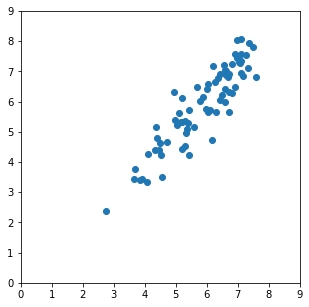

In [69]:
ypredict=GBregr.predict(X_test)
plt.subplots(figsize=(5,5))
plt.scatter(ypredict, np.log(y_test))
_=plt.xlim(0, 9)
_=plt.ylim(0, 9)

### Gradient Boost Regressor *without* variable transformation

0.895585803213845
0.5240679022298117
0.31721282829230163


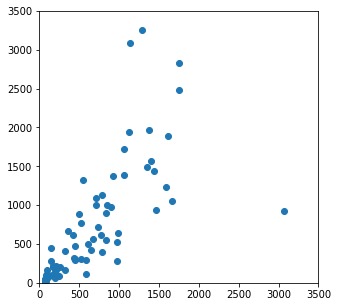

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

GBregr = GradientBoostingRegressor(n_estimators=100, max_depth=2)
GBregr.fit(X_train, y_train)
print(GBregr.score(X_train, y_train))
print(GBregr.score(X_test, y_test))


print((cross_validate(GBregr, X_train, y_train, cv=5)["test_score"]).mean())

ypredict=GBregr.predict(X_test)
plt.subplots(figsize=(5,5))
plt.scatter(ypredict, y_test)
_=plt.xlim(0,3500)
_=plt.ylim(0,3500)


### Linear Regression

In [26]:
X_linear=X.drop(["Latitude", "Longitude"], axis=1)
y_linear=maindf.Ave_Trips_Per_Month
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.25, random_state=40)

In [28]:
model = LinearRegression()
model.fit(X_train, np.log(y_train))
print(model.score(X_train, np.log(y_train)))
print(model.score(X_test, np.log(y_test)))


print((cross_validate(model, X_train, np.log(y_train), cv=5)["test_score"]).mean())

0.5740635107188209
0.7512832316385996
0.5271376670253531


In [30]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


print((cross_validate(model, X_train, y_train, cv=5)["test_score"]).mean())

0.6069337104520641
0.6276182831865805
0.4662353934195833


### Random Forest with variable transformation

In [61]:
forest = RandomForestRegressor()
parameters = {'n_estimators':[10,20,30,40,50], 'max_depth':[2,3,4,5,6,7,8,9,10]}
clf = GridSearchCV(forest, parameters, cv=5)
clf.fit(X_train, np.log(y_train))
clf.best_params_

/Users/kkim14/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 5, 'n_estimators': 20}

train score: 0.9129772641677325
test score: 0.7973931041657341
mean validation set score: 0.7615185818865255


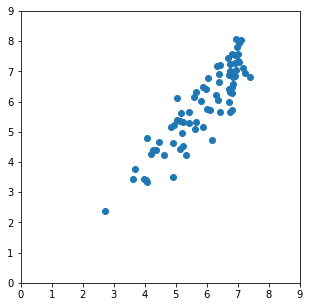

In [62]:
forest = RandomForestRegressor(n_estimators=20, max_depth=5)
forest.fit(X_train, np.log(y_train))
print("train score:",forest.score(X_train, np.log(y_train)))
print("test score:",forest.score(X_test, np.log(y_test)))

print("mean validation set score:",(cross_validate(forest, X_train, np.log(y_train), cv=5)["test_score"]).mean())

ypredict=forest.predict(X_test)
plt.subplots(figsize=(5,5))
plt.scatter(ypredict, np.log(y_test))
_=plt.xlim(0,9)
_=plt.ylim(0,9)

### Random Forest *without* variable transformation

/Users/kkim14/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9207490392113977
0.522025696557916
0.44833225980920427


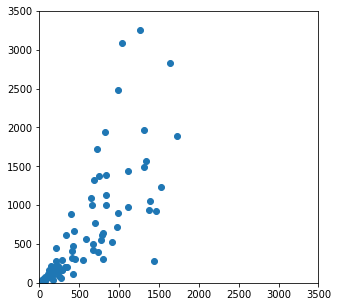

In [46]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

print((cross_validate(forest, X_train, y_train, cv=5)["test_score"]).mean())

ypredict=forest.predict(X_test)
plt.subplots(figsize=(5,5))
plt.scatter(ypredict, y_test)
_=plt.xlim(0,3500)
_=plt.ylim(0,3500)

### Neural Network

In [43]:
n_cols = len(X.columns)

# Set up the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols, )))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/1
224/224 [==============================] - 0s 53us/step - loss: 208229.2388


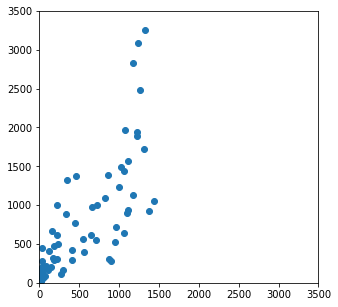

In [47]:
# Fit the model
model.fit(X_train, y_train)

ypredict=model.predict(X_test)

plt.subplots(figsize=(5,5))
plt.scatter(ypredict[:,0], y_test)
_=plt.xlim(0,3500)
_=plt.ylim(0,3500)